In [26]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import joblib
from flask import Flask, request, jsonify

In [68]:
df = pd.read_csv('/content/healthcare-stroke-data.csv')

In [28]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5110 non-null   int64  
 1   gender               5110 non-null   object 
 2   age                  5110 non-null   float64
 3   hypertension         5110 non-null   int64  
 4   heart_disease        5110 non-null   int64  
 5   ever_married         5110 non-null   object 
 6   work_type            4929 non-null   object 
 7   Residence_type       5110 non-null   object 
 8   avg_glucose_level    5110 non-null   float64
 9   bmi                  4909 non-null   float64
 10  smoking_status       5110 non-null   object 
 11  stroke               5110 non-null   int64  
 12  high_blood_pressure  3589 non-null   float64
dtypes: float64(4), int64(4), object(5)
memory usage: 519.1+ KB
None


In [29]:
print("\nDescriptive Statistics:")
print(df.describe(include='all'))


Descriptive Statistics:
                  id  gender          age  hypertension  heart_disease  \
count    5110.000000    5110  5110.000000   5110.000000    5110.000000   
unique           NaN       3          NaN           NaN            NaN   
top              NaN  Female          NaN           NaN            NaN   
freq             NaN    2994          NaN           NaN            NaN   
mean    36517.829354     NaN    43.226614      0.097456       0.054012   
std     21161.721625     NaN    22.612647      0.296607       0.226063   
min        67.000000     NaN     0.080000      0.000000       0.000000   
25%     17741.250000     NaN    25.000000      0.000000       0.000000   
50%     36932.000000     NaN    45.000000      0.000000       0.000000   
75%     54682.000000     NaN    61.000000      0.000000       0.000000   
max     72940.000000     NaN    82.000000      1.000000       1.000000   

       ever_married work_type Residence_type  avg_glucose_level          bmi  \
count 

In [30]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
id                        0
gender                    0
age                       0
hypertension              0
heart_disease             0
ever_married              0
work_type               181
Residence_type            0
avg_glucose_level         0
bmi                     201
smoking_status            0
stroke                    0
high_blood_pressure    1521
dtype: int64


In [31]:
#  Handling Missing Values
# Convert 'high_blood_pressure' to float and handle missing values
df['high_blood_pressure'] = df['high_blood_pressure'].astype(float)

# Impute missing values
mode_value = df['work_type'].mode()[0]
df['work_type'] = df['work_type'].fillna(mode_value)

# Replace missing values in 'bmi' with the median
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# Replace missing values in 'high_blood_pressure' with the median (or mean, based on distribution)
df['high_blood_pressure'] = df['high_blood_pressure'].fillna(df['high_blood_pressure'].median())


In [32]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                    0
smoking_status         0
stroke                 0
high_blood_pressure    0
dtype: int64


Text(0.5, 1.0, 'Age Distribution')

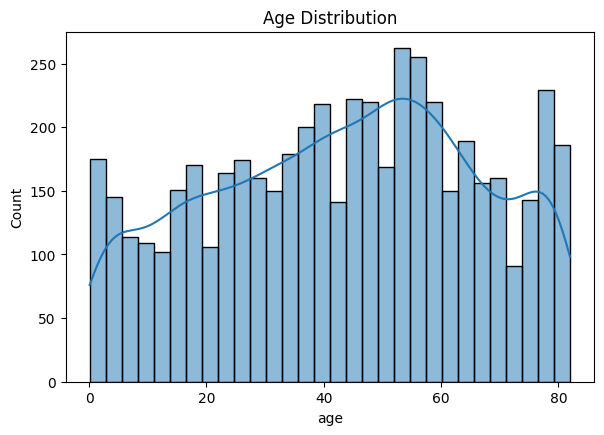

In [33]:
# Data Visualizations
# Distributions of key features
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution')

Text(0.5, 1.0, 'Glucose Level Distribution')

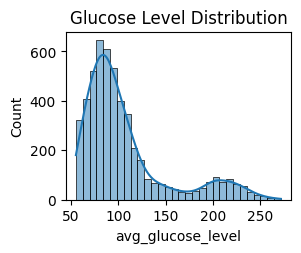

In [34]:
plt.subplot(2, 2, 2)
sns.histplot(df['avg_glucose_level'], bins=30, kde=True)
plt.title('Glucose Level Distribution')

Text(0.5, 1.0, 'BMI Distribution')

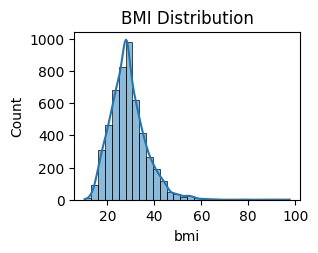

In [35]:
plt.subplot(2, 2, 3)
sns.histplot(df['bmi'], bins=30, kde=True)
plt.title('BMI Distribution')

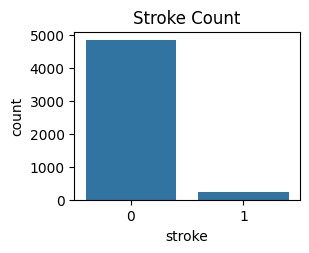

In [36]:
plt.subplot(2, 2, 4)
sns.countplot(x='stroke', data=df)
plt.title('Stroke Count')
plt.show()

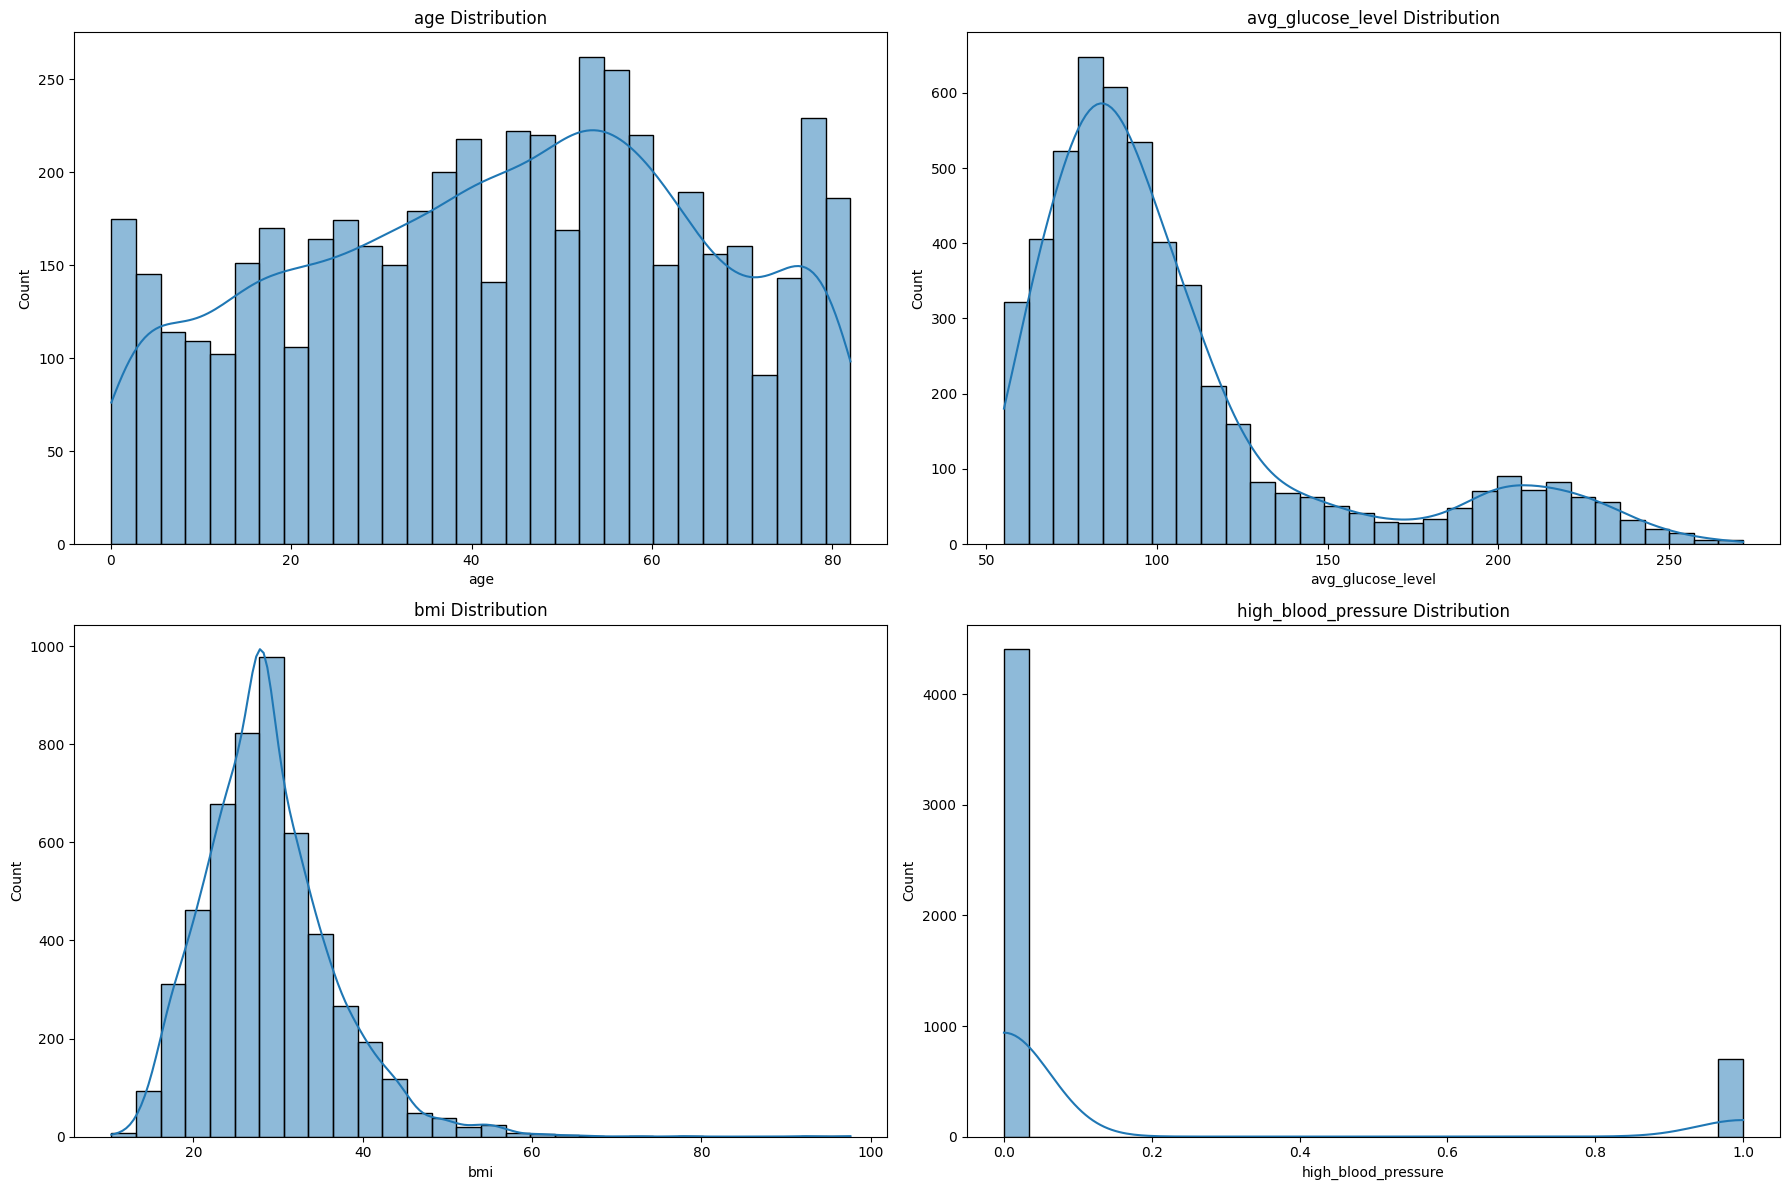

In [37]:
plt.figure(figsize=(18, 12))

# Numerical Features Distribution
num_features = ['age', 'avg_glucose_level', 'bmi', 'high_blood_pressure']
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'{feature} Distribution')

plt.tight_layout()
plt.show()

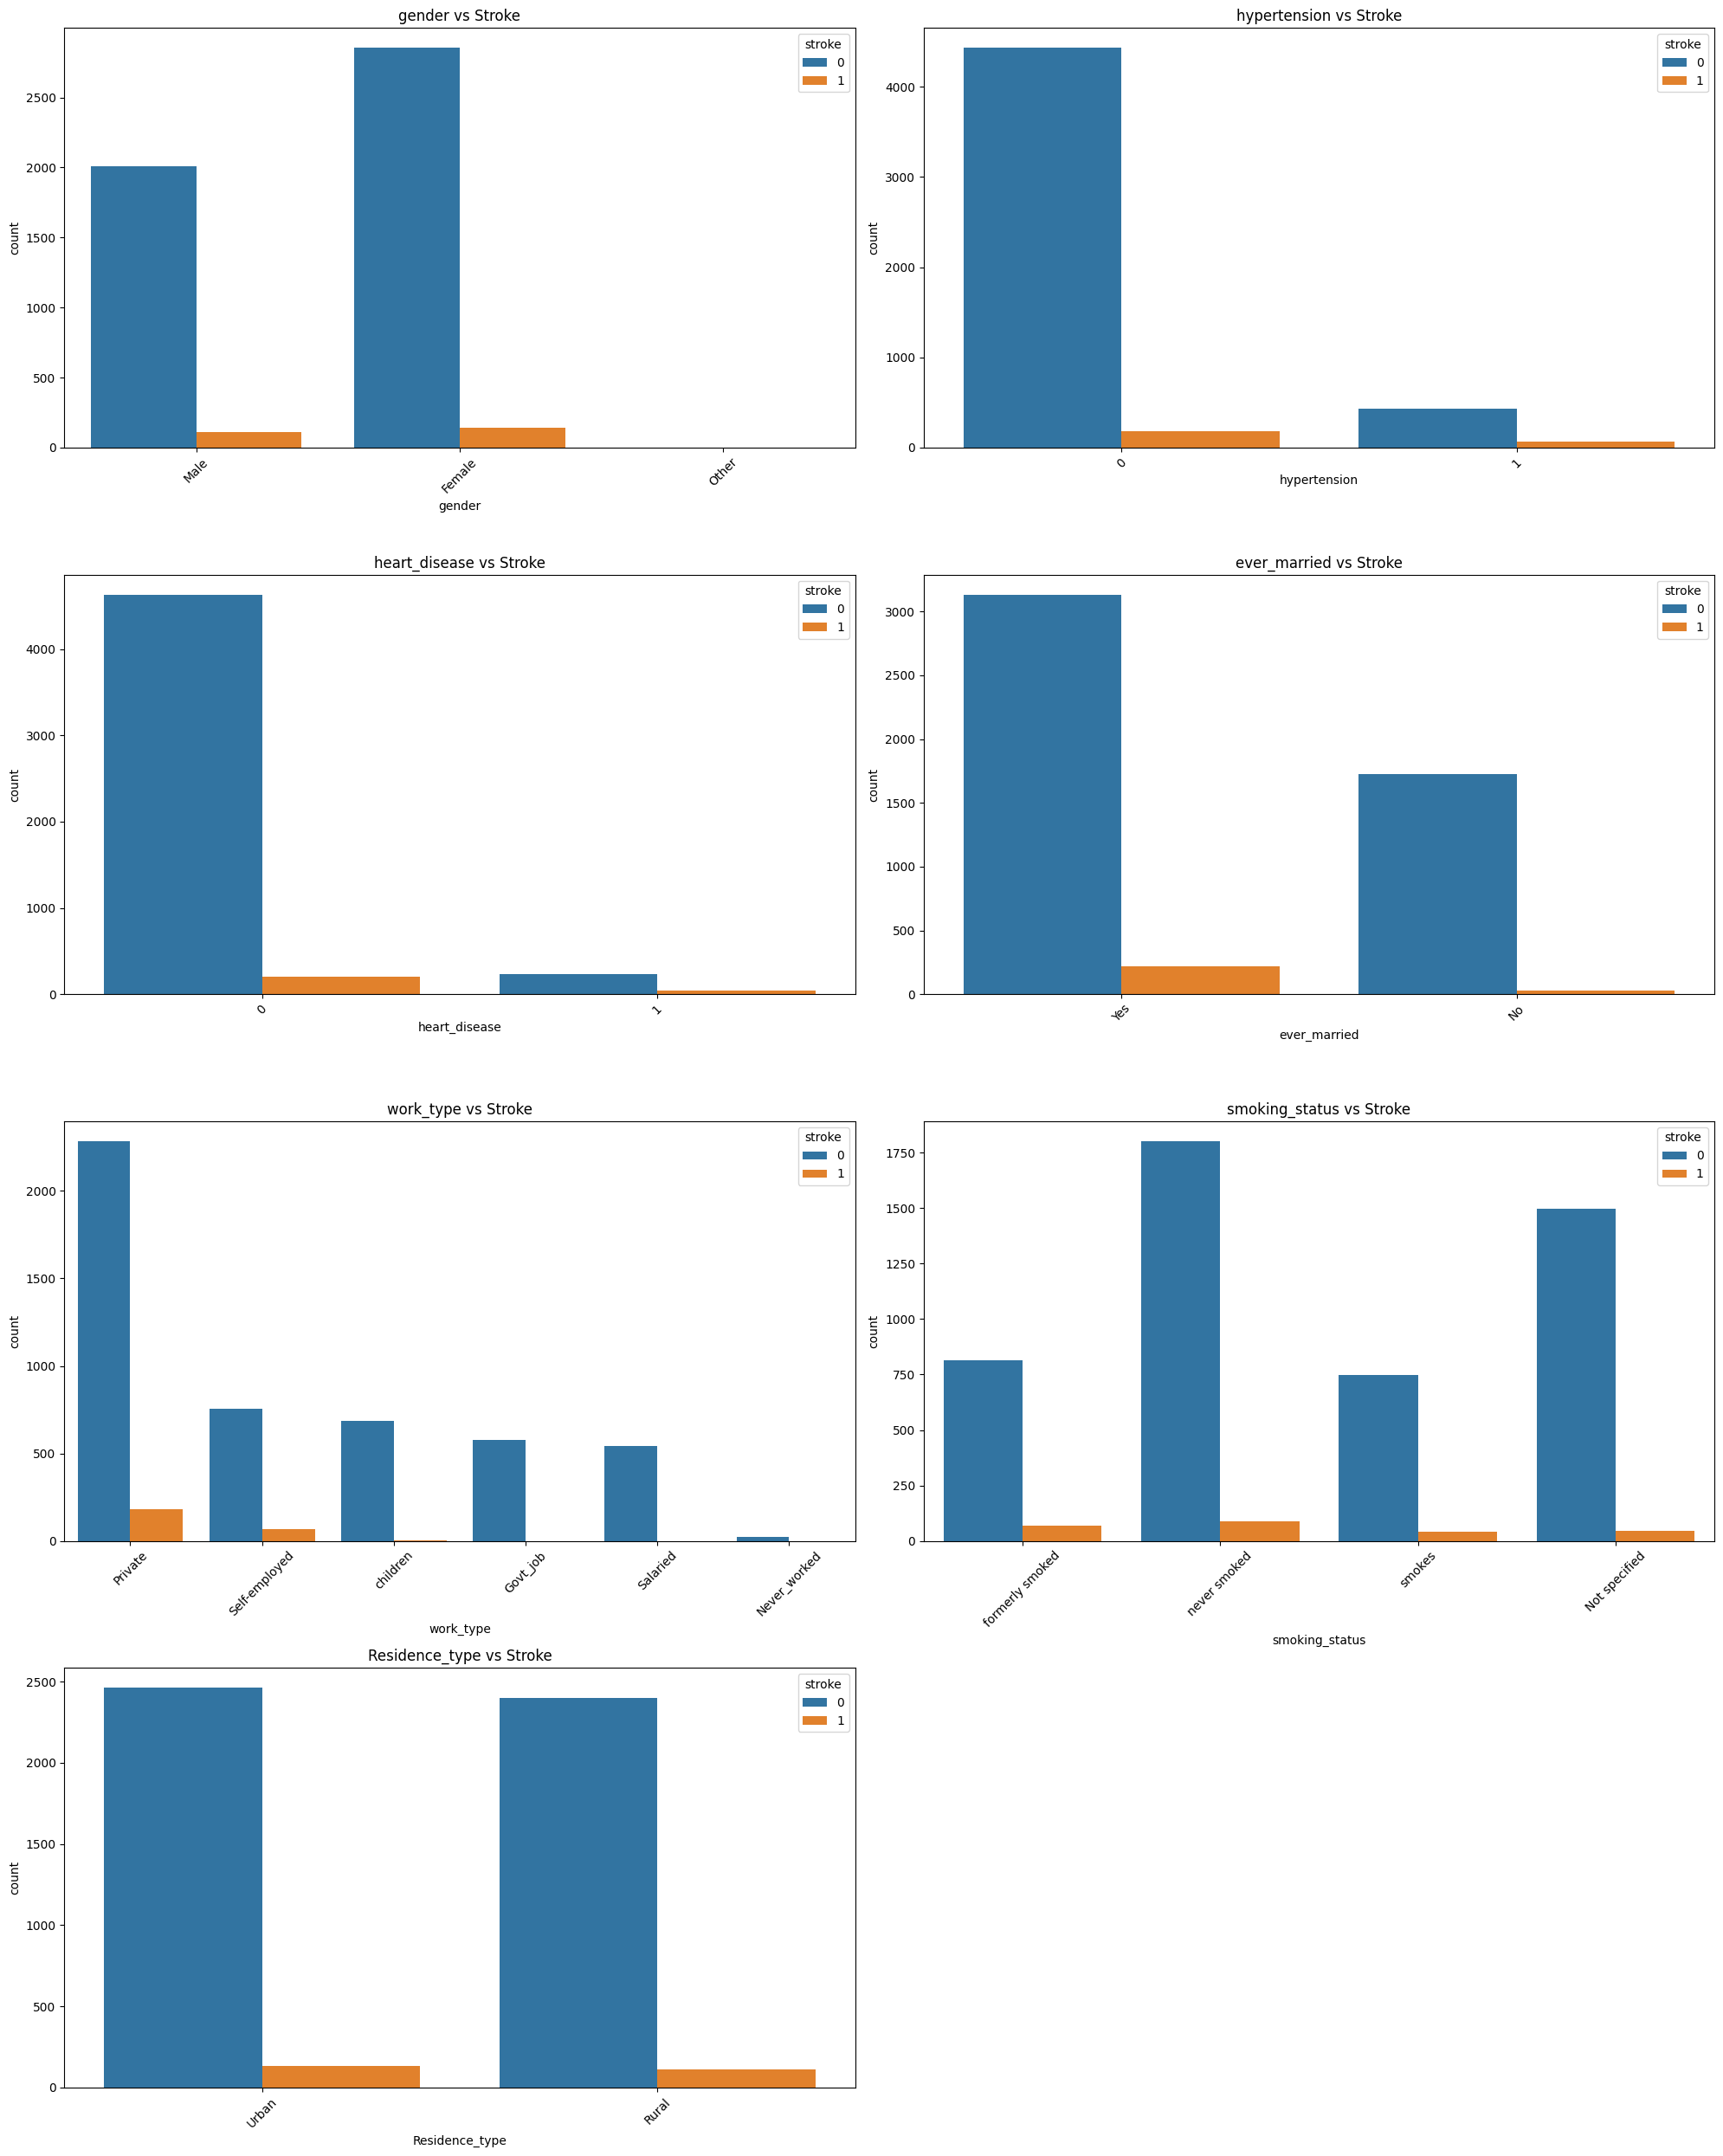

In [39]:
# Categorical Features Analysis
cat_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'smoking_status', 'Residence_type']
plt.figure(figsize=(20, 25))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(4, 2, i)
    if df[feature].nunique() > 4:  # To Handle smoking_status with many categories
        sns.countplot(x=feature, hue='stroke', data=df, order=df[feature].value_counts().index)
    else:
        sns.countplot(x=feature, hue='stroke', data=df)
    plt.title(f'{feature} vs Stroke')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

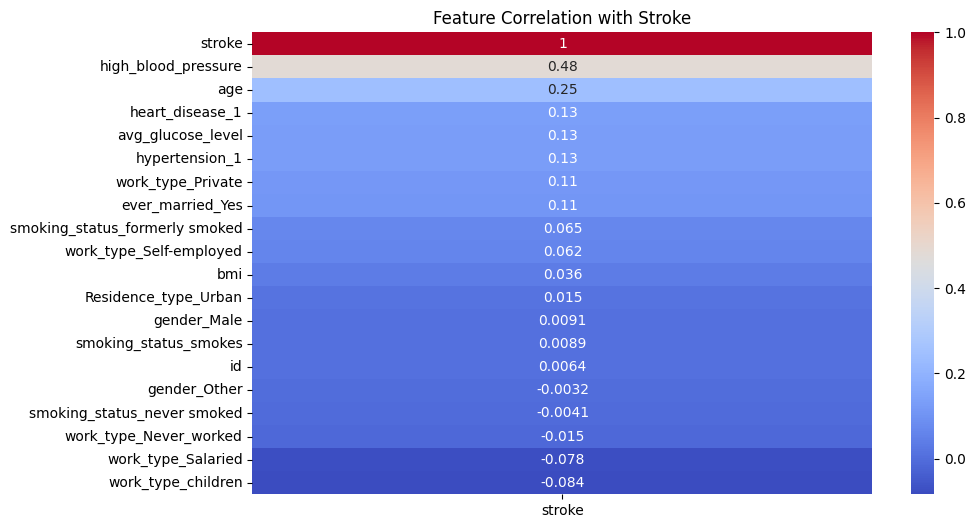

In [41]:
# Correlation Analysis with Corrected stroke
df_encoded = pd.get_dummies(df, columns=[col for col in cat_features if col != 'stroke'], drop_first=True)
plt.figure(figsize=(10,6))
sns.heatmap(df_encoded.corr()[[('stroke')]].sort_values(by='stroke', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation with Stroke')
plt.show()

In [42]:
#  Machine Learning Modelling with Enhanced Preprocessing
# Drop irrelevant column
df = df.drop('id', axis=1)

# Define features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [44]:
numeric_features = ['age', 'avg_glucose_level', 'bmi', 'high_blood_pressure']
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [45]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [46]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [47]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [52]:
# Corrected Machine Learning Modelling
from imblearn.pipeline import Pipeline

# Defining preprocessing and modeling pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ))
])

In [55]:
# Training and evaluating
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("\nBase Model Performance:", y_pred)


Base Model Performance: [0 0 0 ... 0 0 0]


In [56]:
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       972
           1       0.56      0.70      0.62        50

    accuracy                           0.96      1022
   macro avg       0.77      0.84      0.80      1022
weighted avg       0.96      0.96      0.96      1022

ROC AUC Score: 0.83559670781893


In [57]:
from imblearn.pipeline import Pipeline

# pipeline structure
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2']
}

In [58]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

In [59]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi',
                                                                          'high_blood_pressure']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(hand...
                                                                          'work_type',
                                                                          'Residence_type',
                                                                          'smoking_status'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__n_estimators': [100, 200]},
             scoring='recall')

In [60]:
print("\nBest Parameters:", grid_search.best_params_)
y_pred_tuned = grid_search.best_estimator_.predict(X_test)


Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100}


In [61]:
print("\nTuned Model Performance:")
print(classification_report(y_test, y_pred_tuned))
print("Tuned ROC AUC Score:", roc_auc_score(y_test, y_pred_tuned))


Tuned Model Performance:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       972
           1       0.53      0.82      0.64        50

    accuracy                           0.95      1022
   macro avg       0.76      0.89      0.81      1022
weighted avg       0.97      0.95      0.96      1022

Tuned ROC AUC Score: 0.8909670781893003


In [62]:
# Save model
joblib.dump(grid_search.best_estimator_, 'best_stroke_model.pkl')

['best_stroke_model.pkl']